<a href="https://colab.research.google.com/github/sacamiso/AjedrezDistribuidos/blob/main/instrucciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entregable 2: Construyendo un modelo de clasificación aplicando *fine-tuning*

En este notebook se muestra cómo crear un modelo de clasificación de imágenes utilizando la técnica de *transfer-learning* conocida como *fine-tuning*.

Para ello vamos a utilizar la librería [fastAI](https://www.fast.ai/). Este notebook está inspirado en el curso asociado a dicha librería. 

En esta práctica vamos a hacer un uso intensivo de la GPU, así que es importante activar su uso desde la opción *Notebook settings* del menú *Edit* . 

## Carga de librerías

Comenzamos instalando y cargando las librerías que vamos a necesitar en esta práctica. La librería ``fastai`` nos proporciona los distintos algoritmos de aprendizaje profundo y la librería ``os`` la utilizamos para la gestión de ficheros. 

In [1]:
!pip install fastai -Uq

In [2]:
from fastai.vision.all import *
import os
from google.colab import files
from sklearn.model_selection import train_test_split
import shutil

## Creando nuestro dataset de imágenes

El primer paso en cualquier proyecto de clasificación de imágenes es construir un dataset de imágenes anotadas. Aunque existen muchos datasets disponibles vamos a ver que con las técnicas explicadas en este notebook se pueden construir buenos modelos de clasificación para cualquier problema. 

En concreto, nuestro objetivo va a ser construir un modelo capaz de distinguir entre los personajes de la serie [Futurama](https://es.wikipedia.org/wiki/Futurama). En concreto queremos saber si quien aparece en una imagen es Fry, Bender o Leela. 

<img src="https://purepng.com/public/uploads/large/purepng.com-futurama-leela-fry-benderfuturamaanimationsciencefictioncartoonroberto-17015286039035k1si.png" alt="Fry, Bender y Leela" style="width: 50px;"/>



### Creando el dataset

Para crear nuestro dataset vamos a utilizar imágenes adquiridas desde Google Imágenes. El proceso que seguimos para construir nuestro dataset viene explicado en el blog de [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/). En concreto hemos buscado imágenes de Fry, Leela y Bender y hemos creado los ficheros fry.csv, bender.csv y leela.csv que contienen las URLs donde se encuentran las imágenes de cada uno de estos personajes.

In [3]:
!wget https://raw.githubusercontent.com/ts1819/datasets/master/practica3/bender.csv -O bender.csv
!wget https://raw.githubusercontent.com/ts1819/datasets/master/practica3/fry.csv -O fry.csv
!wget https://raw.githubusercontent.com/ts1819/datasets/master/practica3/leela.csv -O leela.csv

--2023-04-26 14:17:21--  https://raw.githubusercontent.com/ts1819/datasets/master/practica3/bender.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37776 (37K) [text/plain]
Saving to: ‘bender.csv’

bender.csv          100%[===================>]  36.89K  --.-KB/s    in 0s      

2023-04-26 14:17:21 (79.4 MB/s) - ‘bender.csv’ saved [37776/37776]

--2023-04-26 14:17:21--  https://raw.githubusercontent.com/ts1819/datasets/master/practica3/fry.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39497 (39K) [text/plain]
Saving to: ‘f

### Descargando las imágenes y organizando las carpetas

Habitualmente para crear modelos de clasificación de imágenes se crea una carpeta para cada clase de imagen (en este caso necesitaremos crear tres carpetas, una para fry, otra para bender y otra para leela).

En nuestro caso además de crear las carpetas debemos descargar las imágenes para ello debemos ejecutar las siguientes celdas (notad que el código es identico en los tres casos y lo único que cambia es la clase de las imágenes).

Es posible que al intentar descargar alguna imagen se produzcan errores, pero no son relevantes (solo indican que esa imagen no se ha podido descargar).



In [4]:
path = Path('data/futurama')

In [5]:
folder = 'leela'
file = 'leela.csv'
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)
os.rename(file,path/file)
# Como mucho descargamos 200 imágenes
download_images(dest,path/file,max_pics=200)

In [6]:
folder = 'fry'
file = 'fry.csv'
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)
os.rename(file,path/file)
# Como mucho descargamos 200 imágenes
download_images(dest,path/file,max_pics=200)

In [7]:
folder = 'bender'
file = 'bender.csv'
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)
os.rename(file,path/file)
download_images(dest,path/file,max_pics=200)

Puede ocurrir que algunas imágenes tengan un formato que no pueda ser abierto por la librería, por lo que vamos a eliminarlas con la siguiente instrucción.

In [8]:
for im in verify_images(get_image_files(path)):
    os.remove(str(im))

A continuación vamos a partir nuestro dataset en un conjunto de entrenamiento y en otro de test (usaremos el 80% de las imágenes para entrenar y el 20% para test). Para partir el dataset debemos organizarlo con la siguiente estructura de directorios:

```
data
└── futurama
    ├── test
    │   ├── bender
    │   ├── fry
    │   └── leela
    └── train
        ├── bender
        ├── fry
        └── leela
```

Es decir tenemos una carpeta train y otra carpeta test. Dentro de la carpeta train tendremos tantas carpetas como clases tiene nuestro dataset, y análogamente para la carpeta test. 

Comenzamos creando la estructura de carpetas.


In [9]:
(path/'train/bender').mkdir(parents=True,exist_ok=True)
(path/'train/leela').mkdir(parents=True,exist_ok=True)
(path/'train/fry').mkdir(parents=True,exist_ok=True)
(path/'test/bender').mkdir(parents=True,exist_ok=True)
(path/'test/leela').mkdir(parents=True,exist_ok=True)
(path/'test/fry').mkdir(parents=True,exist_ok=True)

A continuación vamos a partir las imágenes descargadas previamente y las almacenamos en la carpeta correspondiente.

In [10]:
trainBender, testBender = train_test_split(get_image_files(path/'bender'),test_size=0.2,random_state=15)
trainLeela, testLeela = train_test_split(get_image_files(path/'leela'),test_size=0.2,random_state=15)
trainFry, testFry = train_test_split(get_image_files(path/'fry'),test_size=0.2,random_state=15)

In [11]:
for x in trainBender:
  shutil.move(str(x),path/('train/bender/'+x.name))

for x in trainLeela:
  shutil.move(str(x),path/('train/leela/'+x.name))

for x in trainFry:
  shutil.move(str(x),path/('train/fry/'+x.name))

for x in testBender:
  shutil.move(str(x),path/('test/bender/'+x.name))

for x in testLeela:
  shutil.move(str(x),path/('test/leela/'+x.name))

for x in testFry:
  shutil.move(str(x),path/('test/fry/'+x.name))

Por último eliminamos aquellas carpetas y ficheros que ya no vamos a utilizar. 

In [12]:
shutil.rmtree('data/futurama/bender')
shutil.rmtree('data/futurama/fry')
shutil.rmtree('data/futurama/leela')
os.remove('data/futurama/bender.csv')
os.remove('data/futurama/fry.csv')
os.remove('data/futurama/leela.csv')

### Cargando el dataset

A continuación vamos a mostrar cómo se carga el dataset para poder posteriormente crear nuestro modelo. Este proceso se hace en dos pasos. Primero se construye un objeto `DataBlock` y a continuación se construye un objeto `DataLoader` a partir del `DataBlock`. Tienes más información sobre estos objetos en la documentación de [FastAI](https://docs.fast.ai/tutorial.datablock.html).

### Datablock

Comenzamos construyendo el objeto `DataBlock`. A continuación explicaremos cada una de sus componentes. 

In [13]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=aug_transforms(size=256,min_scale=0.75))

Vamos a ver las distintas componentes del `DataBlock`.

- El atributo `blocks` sirve para indicar el tipo de nuestros datos. Como estamos en un problema de clasificación de imágenes, tenemos que la entrada de nuestro modelo será una imagen, es decir un `ImageBlock`, y la salida será una categoría, es decir un `CategoryBlock`. Por lo tanto indicamos que `blocks = (ImageBlock, CategoryBlock)`.
- El atributo `get_items` debe proporcionar una función para leer los datos. En nuestro caso queremos leer una serie de imágenes que estarán almacenadas en un `path`. Para ello usamos la función `get_image_files`. Puedes ver qué hace exactamente esta función ejecutando el comando `??get_image_files`.
- El atributo `splitter` nos indica cómo partir el dataset. Daros cuenta que tenemos un conjunto de entrenamiento y uno de test, pero para entrenar nuestro modelo y probar distintas alternativas nos interesa usar un conjunto de validación, que lo vamos a tomar de forma aleatorea a partir de nuestro conjunto de entrenamiento usando un 20% del mismo. Para ello usaremos el objeto `RandomSplitter(valid_pct=0.2,seed=42)`.
- El atributo `get_y` sirve para indicar cómo extraemos la clase a partir de nuestros datos. La función `get_image_files` nos proporciona una lista con los paths a las imágenes de nuestro dataset. Si nos fijamos en dichos paths, la clase de cada imagen viene dada por la carpeta en la que está contenida, por lo que podemos usar el método `parent_label` para obtener la clase de la misma. 

Por último, los atributos `item_tfms` y `batch_tfms` sirven para aplicar una técnica conocida como *preescalado* (o *presizing*).   

### Dataloader

Pasamos ahora a construir nuestro `DataLoader` que se construye a partir del `DataBlock` construido anteriormente indicándole el path donde se encuentran nuestras imágenes. Además podemos configurar el `DataLoader` indicándole el tamaño del batch que queremos utilizar. Al trabajar con GPUs es importante que usemos batches de tamaño 2^n para optimizar el uso de la GPU.

In [14]:
trainPath = Path('data/futurama/train')

In [15]:
dls = db.dataloaders(trainPath,bs=128)

A continuación mostramos un batch de nuestro `DataLoader`. Es conveniente comprobar que realmente se han cargado las imágenes y sus anotaciones de manera correcta. 

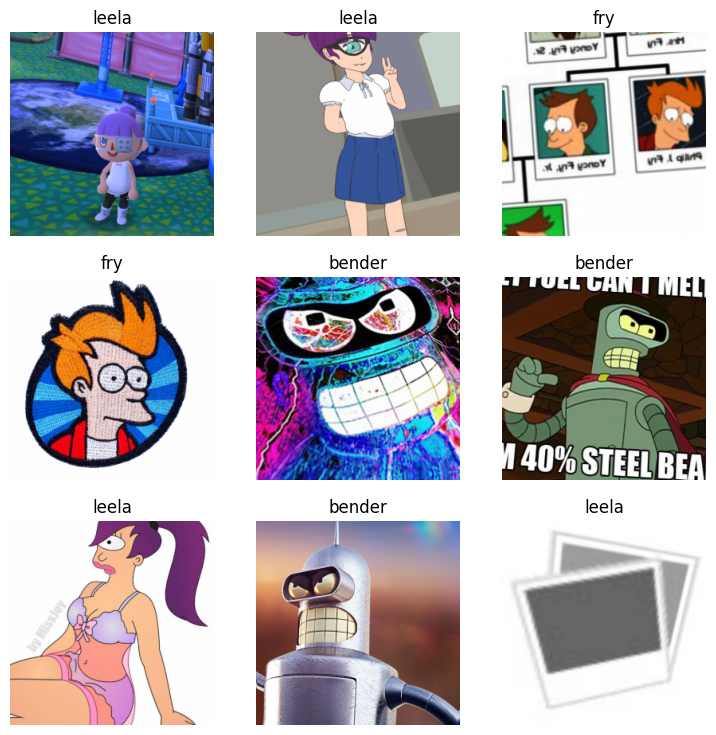

In [16]:
dls.show_batch()

## Creando el modelo de predicción

A continuación vamos a crear nuestra red convolucional usando *transfer learning* y utilizando como base la arquitectura [ResNet 18](https://arxiv.org/abs/1512.03385); aunque existen otros [modelos disponibles](https://wandb.ai/capecape/imagenette_timm/reports/Checking-Out-the-New-fastai-timm-Integration--VmlldzoxOTMzNzMw) este modelo proporciona buenos resultados. Al crear nuestra red convolucional también debemos indicar la [métrica](https://docs.fast.ai/metrics.html#metrics) que vamos a utilizar para medir el rendimiento del modelo, en este caso vamos a usar el error_rate y la accuracy.

La primera vez que se ejecuta la siguiente instrucción puede llevar algún tiempo debido a que se tienen que descargar los pesos asociados a la red ResNet 18. 



In [17]:
learn = vision_learner(dls,resnet18,metrics=accuracy).to_fp16()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]


### Entrenando la red

El siguiente paso es entrenar la red. Para ello vamos a utilizar el [siguiente procedimiento](https://sgugger.github.io/the-1cycle-policy.html) basado en la idea de fine-tuning:

1. En primer lugar se dejan fijos (congelados) los pesos de la mayoría de capas de la red y sólo se actualizan los de las últimas capas. 
2. Se descongelan todas las capas de la red. 
3. Se reentrenan todas las capas de la red pero utilizando distintos *learning rates* en cada capa. 

La librería fastai proporciona toda la funcionalidad necesaria para llevar a cabo este proceso mediante el método `fine_tune`.

In [18]:
learn.fine_tune(10,base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.833979,4.328017,0.311475,00:11


epoch,train_loss,valid_loss,accuracy,time
0,2.082493,3.323290,0.327869,00:07
1,2.027723,2.500919,0.344262,00:07
2,1.882915,1.790888,0.360656,00:07
3,1.796724,1.316808,0.459016,00:06
4,1.679397,1.020171,0.557377,00:08
5,1.571421,0.852117,0.655738,00:06
6,1.460321,0.737415,0.655738,00:07
7,1.357010,0.670988,0.704918,00:07
8,1.277049,0.639641,0.688525,00:06
9,1.197805,0.622153,0.688525,00:08


Para su uso posterior, es conveniente exportar el modelo una vez entrenado. 

In [19]:
learn.export()

Podemos ver que dicho modelo se ha guardado en el mismo directorio donde nos encontramos.

In [20]:
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Interpretación de los resultados

Vamos a interpretar los resultados utilizando la matriz de confusión.

A continuación se crear una interpretación de los resultados obtenidos con la misma. 

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

Por último mostramos la matriz de confusión obtenida. Además de la matriz de confusión se puede obtener [otra información](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation).

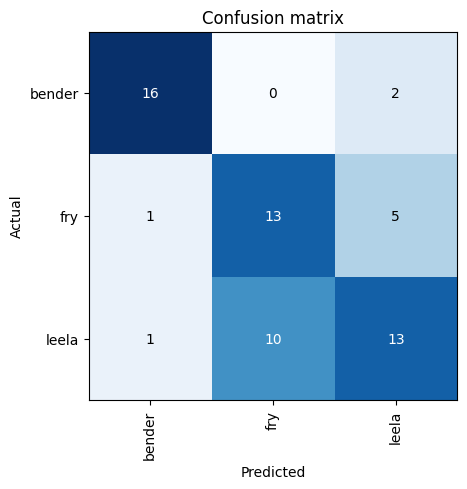

In [22]:
interp.plot_confusion_matrix()

Como podemos ver en la matriz de confusión anterior, el modelo tiende a confundir a Leela con Fry, esto puede deberse a que tengamos cierto ruido en nuestras imágenes (por ejemplo, imágenes que contengan a ambos personajes). Por lo tanto es conveniente limpiar nuestro dataset.

### Evaluando el modelo en el conjunto de test

Para poder evaluar nuestro modelo en el conjunto de test debemos crear un nuevo `DataBlock` y un nuevo `DataLoader`. La única diferencia con el `DataBlock` utilizado previamente es que para hacer la partición del dataset usamos un objeto de la clase `GrandparentSplitter` indicando que el conjunto de validación es nuestro conjunto de test. En el caso del `DataLoader`, la diferencia con el definido anteriormente es que cambiamos la ruta al path. 

In [23]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

Para trabajar con este dataloader debemos modificar nuestro objeto `Learner`. En concreto su atributo `dls`. 

In [24]:
learn.dls = dlsTest

Ahora podemos evaluar nuestro modelo usando el método `validate`.

In [25]:
learn.validate()

(#2) [1.0238903760910034,0.6410256624221802]

El método `validate` nos devuelve dos valores: el valor de la función de pérdida, y el valor de nuestra métrica (la accuracy en este caso). Por lo que podemos ver que el modelo tiene una accuracy en el conjunto de test de aproximadamente un 70% (esto puede variar dependiendo de la ejecución). 

## Limpiando el dataset

Como hemos comentado anteriormente puede ocurrir que haya imágenes en nuestro dataset que no deberían estar ahí.


In [26]:
from fastai.vision.widgets import ImageClassifierCleaner

En primer lugar podemos ver aquellas imágenes que tienen una mayor pérdida (es decir, aquellas que el modelo clasifica peor). Esto se puede hacer con ``.plot_top_losses``. 

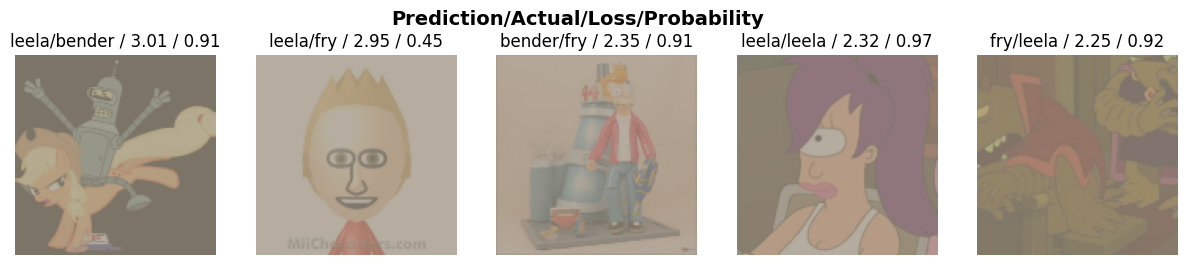

In [27]:
interp.plot_top_losses(5,nrows=1)

A continuación podemos utilizar el siguiente widget para limpiar el dataset.

In [28]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

Una vez que hayamos seleccionados para eliminar, podemos usar el siguiente comando.

In [29]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

Como se puede apreciar hay ciertas imágenes en nuestro dataset que no son correctas, por lo que deberíamos hacer una limpieza del mismo para conseguir mejores resultados. 


### Usando el modelo

Vamos a ver cómo usar el modelo ante una nueva imagen. Para ello lo primero que vamos a hacer es cargar dicho modelo. 

In [30]:
learn_inf = load_learner('export.pkl')

Vamos a probar nuestro modelo con una nueva imagen, en este caso de Fry. Comenzamos descargando dicha imagen, y a continuación la abrimos.


In [31]:
!wget https://descubrebulgaria.files.wordpress.com/2016/02/27387-philip-j-fry-futurama-2880x1800-cartoon-wallpaper.jpg?w=300 -O fry.png

--2023-04-26 14:27:34--  https://descubrebulgaria.files.wordpress.com/2016/02/27387-philip-j-fry-futurama-2880x1800-cartoon-wallpaper.jpg?w=300
Resolving descubrebulgaria.files.wordpress.com (descubrebulgaria.files.wordpress.com)... 192.0.72.16, 192.0.72.17
Connecting to descubrebulgaria.files.wordpress.com (descubrebulgaria.files.wordpress.com)|192.0.72.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7799 (7.6K) [image/jpeg]
Saving to: ‘fry.png’

fry.png             100%[===================>]   7.62K  --.-KB/s    in 0s      

2023-04-26 14:27:35 (60.3 MB/s) - ‘fry.png’ saved [7799/7799]



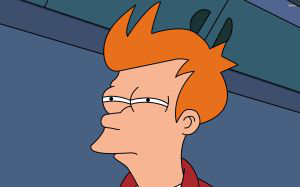

In [32]:
import PIL
img = PILImage.create('fry.png')
img

Ahora podemos usar dicho modelo para hacer inferencia con una nueva imagen mediante el método predict. En nuestro caso vamos a usar una imagen del conjunto de test.

In [33]:
learn_inf.predict('fry.png')

('fry', tensor(1), tensor([7.8626e-03, 9.9139e-01, 7.4700e-04]))

La función anterior devuelve tres valores:
- La clase (buildings en este caso).
- El índice asociado a dicha clase. 
- Las probabilidades para cada una de las categorías.  

## Creando una aplicación para nuestro modelo

Es fundamental que los modelos sean usables, por lo que es conveniente proporcionar una interfaz secilla que permita usar nuestros modelos. Para ello, vamos a usar dos herramientas: [Gradio](https://gradio.app/) y los [espacios de HuggingFace](https://huggingface.co/spaces). En concreto vamos a ver cómo construir la siguiente [aplicación](https://huggingface.co/spaces/AP2223/Practica1).

En primer lugar es necesario que crees una [cuenta en HuggingFace](https://huggingface.co/join). Este paso sólo hay que realizarlo una vez. Además debes  [crear un token de escritura](https://huggingface.co/docs/hub/security-tokens).

Una vez realizados esos dos pasos vamos a descargar una librería que permita subir nuestro modelo a HuggingFace. 

In [34]:
!pip install huggingface_hub["fastai"] -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.5 MB/s eta 0:00:00


A continuación nos autenticamos en HuggingFace con el token de escritura creado previamente. 

In [35]:
from huggingface_hub import notebook_login

notebook_login()

Finalmente, para subir nuestro modelo debemos indicar nuestro nombre de usuario de HuggingFace y un nombre para nuestro modelo. En la siguiente instrucción cambia joheras por tu nombre de usuario.

In [ ]:
from huggingface_hub import push_to_hub_fastai

# repo_id = "YOUR_USERNAME/YOUR_LEARNER_NAME"
repo_id = "joheras/futurama"

push_to_hub_fastai(learner=learn, repo_id=repo_id)

Al ejecutar la celda anterior aparecerá una URL donde podrás encontrar tu modelo. Vamos a ver cómo crear una aplicación con el. 

1. Crea un [espacio en HuggingFace](https://huggingface.co/new-space). Al crear dicho espacio usamos como nombre ``entregable2`` y seleccionamos Gradio como SDK. 
2. Descarga dos de las imágenes del dataset.
3. Una vez creado el espacio vamos a la pestaña ``Files and versions``. En dicha pestaña debemos:
  - Subir las dos imágenes que hayas descargado mediante el botón Add file -> Upload file. 
  - Crear un fichero requirements.txt mediante el botón Add file -> Create a new file. Este [fichero](https://huggingface.co/spaces/joheras/futurama/blob/main/requirements.txt) contendrá las librerías que son necesarias instalar para ejecutar nuestra aplicación, en este caso fastai y toml (una librería para ficheros de configuración). 
  - Crear un fichero app.py mediante el botón Add file -> Create a new file. Este [fichero](https://huggingface.co/spaces/joheras/futurama/blob/main/app.py) contendrá el código de la aplicación.
4. Siguiendo estos pasos tendrás una aplicación que podrás ver desde la pestaña ``App`` (la construcción de la aplicación puede llevar unos segundos, el proceso de construcción lo podrás ver pulsando en el botón ``See logs``. 
